<a href="https://colab.research.google.com/github/MaxSMCON/Group3/blob/main/Group3_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import numpy as np, pandas as pd
# import matplotlib.pyplot as plt, seaborn as sns
# from tqdm import tqdm
# import warnings
# # warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


list of countries [Argentina, Australia, Austria, Belgium, Brazil, Canada, Chile, Colombia, Costa Rica, Denmark, Ecuador, Finland, France, Germany, Great Britain, Indonesia, Ireland, Italy, Mexico,
Malaysia, Netherlands, New Zealand, Norway, Peru, Philippines, Poland, Portugal, Singapore, Spain, Sweden, Switzerland, Taiwan, Turkey, USA]

# Spotify Database Exploration

### in order to upload Spotify database from Kaggle you need to download kaggle.json key file. and upload this into the folder: /content

In [3]:
import os

os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Kaggle'

In [4]:
# import os

# os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [5]:
!kaggle datasets download -d pepepython/spotify-huge-database-daily-charts-over-3-years

 84% 161M/191M [00:02<00:00, 64.8MB/s]
100% 191M/191M [00:02<00:00, 71.7MB/s]


In [6]:
!unzip \*.zip && rm *.zip

Archive:  spotify-huge-database-daily-charts-over-3-years.zip
  inflating: Database to calculate popularity.csv  
  inflating: Final database.csv      


In [7]:
# import pandas as pd
# df = pd.read_csv('/content/Final database.csv')

In [8]:
 ! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
 from google.colab import files

# files.upload()

In [10]:
%%capture
!pip install pyspark
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'svg'
sns.set_palette('rainbow')
sns.set_style('whitegrid')
import plotly.express as px
# these 2 lines fix a sporatic loading error in plotly
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
sns.set_style('darkgrid')
# pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col


from sklearn.pipeline import Pipeline
# from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

CSV_FILE= 'Final database.csv'
# CSV_FILE= '/kaggle/input/spotify-huge-database-daily-charts-over-3-years/Database to calculate popularity.csv'

In [11]:
CSV_FILE

'Final database.csv'

In [12]:
spark = SparkSession.builder.master("local[2]").appName("Spotify-Huge-Dataset").getOrCreate() #.enableHiveSupport()
spark

In [13]:

df = spark.read.option("header", True).csv(CSV_FILE, inferSchema=True)
df = df.withColumn("Release_date", F.to_date("Release_date", "yyyy-MM-dd"))
numerical_features = ['danceability', 'energy', 'instrumentalness', 'valence', 'liveliness', 'speechiness', 'acoustics',
                      'instrumentalness', 'tempo', 'duration_ms', 
                      'time_signature', 
                      # 'Days_since_release', 'n_words'
                      ]

for c in numerical_features:
    df = df.withColumn(c, df[c].cast("float"))
    
cols_to_drop = ['syuzhet_norm', 'bing_norm', 'afinn_norm', 'nrc_norm', 'syuzhet', 'bing'] 
for c in cols_to_drop:
    df.drop(c).collect()
    
df.printSchema()
# df.show(n=1, truncate=False, vertical=True)

root
 |-- Country0: string (nullable = true)
 |-- Uri: string (nullable = true)
 |-- Popularity: double (nullable = true)
 |-- Title: string (nullable = true)
 |-- Artist: string (nullable = true)
 |-- Album/Single: string (nullable = true)
 |-- Genre: string (nullable = true)
 |-- Artist_followers: string (nullable = true)
 |-- Explicit: string (nullable = true)
 |-- Album9: string (nullable = true)
 |-- Release_date: date (nullable = true)
 |-- Track_number: string (nullable = true)
 |-- Tracks_in_album: string (nullable = true)
 |-- danceability: float (nullable = true)
 |-- energy: float (nullable = true)
 |-- key: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: float (nullable = true)
 |-- acoustics: float (nullable = true)
 |-- instrumentalness: float (nullable = true)
 |-- liveliness: float (nullable = true)
 |-- valence: float (nullable = true)
 |-- tempo: float (nullable = true)
 |-- duration_ms: float (nul

In [14]:
df.select(["Title","Artist"]).distinct().count()


56241

In [15]:
# df.describe().show()

In [16]:
record = df.select(["Title","Artist"]).distinct().count() / df.select(["Title","Artist"]).count()
print("portion of distinct songs:" ,round(record, 2))

portion of distinct songs: 0.33


In [17]:
print(df[numerical_features])

DataFrame[danceability: float, energy: float, instrumentalness: float, valence: float, liveliness: float, speechiness: float, acoustics: float, instrumentalness: float, tempo: float, duration_ms: float, time_signature: float]


In [18]:
print("Dataset Shape using spark syntax:\n",(df.count(), len(df.columns)))


Dataset Shape using spark syntax:
 (170633, 151)


In [19]:
df.groupBy("Artist").count().orderBy("count", ascending=False).toPandas()

,Artist,count
0,Ariana Grande,1487
1,Drake,1473
2,BTS,1376
3,Taylor Swift,1285
4,XXXTENTACION,989
...,...,...
25519,Aloe Blacc - JID,1
25520,The Script - Christy Dignam,1
25521,Bunbury - Andrés Calamaro,1
25522,Ed Struijlaart,1


In [20]:
# each count is a song that was in the top 200 most played on a day on spotify during the last 3 years
result_df = (df.groupBy("Artist")
               .count()
               .orderBy("count", ascending=False)
               .limit(20)
               .toPandas()
            )
# px.bar(result_df, y='Artist', x='count', title='Most Prolific Artists')

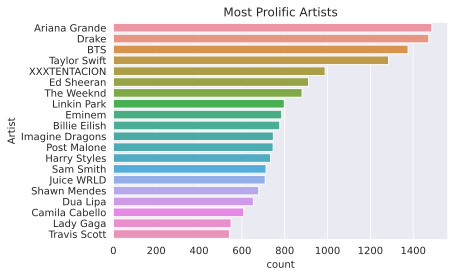

In [21]:
# same as above but with seaborn (sometimes plotly doesn't show up in the published notebok)
sns.barplot(data=result_df, y='Artist', x='count').set_title('Most Prolific Artists');

In [22]:
df.head()

Row(Country0='Global', Uri='https://open.spotify.com/track/6FyRXC8tJUh863JCkyWqtk', Popularity=31833.95, Title='adan y eva', Artist='Paulo Londra', Album/Single='single', Genre='argentine hip hop', Artist_followers='11427104.0', Explicit='False', Album9='Adan y Eva', Release_date=datetime.date(2018, 11, 5), Track_number='1', Tracks_in_album='1', danceability=0.7670000195503235, energy=0.7089999914169312, key='1', loudness='-4.47', mode='1', speechiness=0.335999995470047, acoustics=0.3230000138282776, instrumentalness=0.0, liveliness=0.06759999692440033, valence=0.7200000286102295, tempo=171.9929962158203, duration_ms=258639.0, time_signature=4.0, Genre_new='hip hop', Days_since_release='740.0', Released_after_2017=1.0, Explicit_false=1.0, Explicit_true=0, album31=0, compilation=0, single=1, bolero=0, boy band=0, country36=0, dance/electronic=0, else=0, funk=0, hip hop=1, house=0, indie=0, jazz=0, k-pop=0, latin=0, metal=0, opm=0, pop=0, r&b/soul=0, rap=0, reggae=0, reggaeton=0, rock=0,

In [23]:
df.createOrReplaceTempView("df_table")


In [24]:
print("Now using the SQL Context. We can check it's the same length as before")
query = """
    SELECT Count(*) as Dataset_Length
    FROM df_table
"""
res = spark.sql(query).show()

Now using the SQL Context. We can check it's the same length as before
+--------------+
|Dataset_Length|
+--------------+
|        170633|
+--------------+



In [25]:
# Most popular artist (by sum of popularity of songs) in the USA
query = """
SELECT
                                    Artist, 
       ROUND(SUM(Popularity), 2) AS Populartiy
FROM df_table
WHERE USA == 1
GROUP BY Artist
ORDER BY AVG(Popularity) DESC
LIMIT 10
"""

res = spark.sql(query)
res.show(10, truncate=False)

+------------------------------+----------+
|Artist                        |Populartiy|
+------------------------------+----------+
|Post Malone - Quavo           |130719.15 |
|XXXTENTACION - Trippie Redd   |97016.35  |
|Meek Mill - Drake             |83235.95  |
|Post Malone - 21 Savage       |159633.25 |
|Billie Eilish - Khalid        |79693.9   |
|Marshmello - Bastille         |74560.5   |
|Cardi B - Bad Bunny - J Balvin|74381.6   |
|Migos - Lil Uzi Vert          |70138.2   |
|BlocBoy JB - Drake            |69576.75  |
|Kendrick Lamar - Zacari       |67838.15  |
+------------------------------+----------+



In [26]:
# select only the songs released in 1939
(df.filter(F.year(df['Release_date']) == 1939)
   .select('Title', 'Artist','Release_date', 'Genre')
   .distinct()
   .show(5, truncate=False)
)

+--------------------------------------------+------------+------------+---------------+
|Title                                       |Artist      |Release_date|Genre          |
+--------------------------------------------+------------+------------+---------------+
|moonlight serenade - 2005 remastered version|Glenn Miller|1939-09-01  |adult standards|
+--------------------------------------------+------------+------------+---------------+



In [27]:
query = """
SELECT
        ROUND(Year(Release_date), -1) AS Decade,
        Round(Popularity, 2)          AS Popularity,
                                         Title,
                                         Artist
FROM df_table
INNER JOIN (SELECT Max(Popularity) as mp
            FROM df_table
            WHERE ROUND(Year(Release_date), -1) IS NOT NULL
            AND USA == 1
            GROUP BY ROUND(Year(Release_date), -1)
           ) AS temp
ON temp.mp = df_table.Popularity
ORDER BY Decade ASC, Popularity ASC
"""

res = spark.sql(query)
res.toPandas().drop_duplicates(subset='Decade', keep="last")

,Decade,Popularity,Title,Artist
0,1940,12351.15,white christmas,Bing Crosby - Ken Darby Singers - John Scott T...
1,1950,997.60,mele kalikimaka,Bing Crosby - The Andrews Sisters
2,1960,15575.65,its the most wonderful time of the year,Andy Williams
3,1970,14706.65,a holly jolly christmas - single version,Burl Ives
4,1980,17517.00,last christmas,Wham!
5,1990,32076.40,all i want for christmas is you,Mariah Carey
6,2000,9476.05,feliz navidad,José Feliciano
7,2010,45793.50,no role modelz,J. Cole
13,2020,140487.55,sicko mode,Travis Scott


In [28]:
# highly optimized version of the above query via scalar-aggregate-reduction
query = """
SELECT
    ROUND(Year(Release_date), -1) as Decade,
    ROUND(Max(Popularity), 2) as Popularity,
    SUBSTRING(MAX(CONCAT(LPAD(Popularity, 11, 0), Title)), 12) AS Title,
    SUBSTRING(MAX(CONCAT(LPAD(Popularity, 11, 0), Artist)), 12) AS Artist
FROM
    df_table
WHERE
    ROUND(Year(Release_date), -1) IS NOT NULL
    AND USA == 1
GROUP BY Decade
ORDER BY Decade ASC
"""

spark.sql(query).show()

+------+----------+--------------------+--------------------+
|Decade|Popularity|               Title|              Artist|
+------+----------+--------------------+--------------------+
|  1940|  12351.15|     white christmas|Bing Crosby - Ken...|
|  1950|     997.6|ill be home for c...|         Bing Crosby|
|  1960|  15575.65|    jingle bell rock|         Bobby Helms|
|  1970|  14706.65|what christmas me...|       Stevie Wonder|
|  1980|   17517.0|dreams - 2004 rem...|       Fleetwood Mac|
|  1990|   32076.4|            spoonman|         Soundgarden|
|  2000|   9476.05|       feliz navidad|      José Feliciano|
|  2010|   45793.5|         tongue tied|           Grouplove|
|  2020| 140487.55|       drip too hard|    Lil Baby - Gunna|
+------+----------+--------------------+--------------------+



In [29]:
 # Most popular genres, period.
query = """
SELECT Genre, 
    COUNT(*) AS Tally
FROM df_table
WHERE 
    USA == 1 
    
GROUP BY Genre
ORDER BY Tally DESC
"""
spark.sql(query).show(5)

+-----------+-----+
|      Genre|Tally|
+-----------+-----+
|  dance pop|  919|
|atl hip hop|  671|
|    hip hop|  470|
|        pop|  375|
|melodic rap|  352|
+-----------+-----+
only showing top 5 rows



In [30]:
query = """
SELECT
      ROUND(Year(Release_date), -1) AS Decade,
      Genre, COUNT(Genre)           AS counts,
      ROUND(AVG(Popularity), 1) as popularity_USA

FROM  df_table
WHERE ROUND(Year(Release_date), -1) IS NOT NULL 
      and USA == 1
GROUP BY Decade, Genre
ORDER BY COUNT(Genre) DESC
"""

res = (spark.sql(query)
            .dropDuplicates(subset=['Decade'])
            .orderBy('Decade')
            .show()
      )
# res.toPandas().drop_duplicates(subset='Decade', keep="first")


+------+-----------------+------+--------------+
|Decade|            Genre|counts|popularity_USA|
+------+-----------------+------+--------------+
|  1940|  adult standards|     3|        4432.4|
|  1950|  adult standards|     5|         379.7|
|  1960|  adult standards|     8|        4657.0|
|  1970|     classic soul|     9|         196.6|
|  1980|       album rock|    29|        1020.3|
|  1990|       album rock|    15|         186.4|
|  2000|alternative metal|    19|         238.8|
|  2010|        dance pop|    39|         736.7|
|  2020|        dance pop|   865|        4442.0|
+------+-----------------+------+--------------+



In [31]:
query = """
SELECT
      ROUND(Year(Release_date), -1) AS Decade,
      Genre, COUNT(Genre)           AS counts,
      ROUND(AVG(Popularity), 1) as popularity_Canada

FROM  df_table
WHERE ROUND(Year(Release_date), -1) IS NOT NULL 
      and Canada == 1
GROUP BY Decade, Genre
ORDER BY COUNT(Genre) DESC
"""

res = (spark.sql(query)
            .dropDuplicates(subset=['Decade'])
            .orderBy('Decade')
            .show()
      )
# res.toPandas().drop_duplicates(subset='Decade', keep="first")

+------+-----------------+------+-----------------+
|Decade|            Genre|counts|popularity_Canada|
+------+-----------------+------+-----------------+
|  1940|  adult standards|     3|           4481.1|
|  1950|  adult standards|     5|            474.0|
|  1960|  adult standards|     9|           4463.0|
|  1970|  adult standards|     9|           2667.5|
|  1980|       album rock|    28|           1735.3|
|  1990|   canadian indie|    17|            265.5|
|  2000|alternative metal|    15|            303.1|
|  2010|        dance pop|    22|           1592.6|
|  2020|        dance pop|   802|           6343.3|
+------+-----------------+------+-----------------+



In [32]:
query = """
SELECT Title, Artist, Release_date, MAX(Popularity)
FROM df_table
WHERE Artist == "Paulo Londra"
GROUP BY Title, Artist, Release_date
LIMIT 10
"""

res = spark.sql(query).show()

+----------------+------------+------------+-----------------+
|           Title|      Artist|Release_date|  max(Popularity)|
+----------------+------------+------------+-----------------+
|      adan y eva|Paulo Londra|  2019-05-23|57194.60000000001|
|         tal vez|Paulo Londra|  2019-04-03|22539.99999999998|
|         tal vez|Paulo Londra|  2019-05-23| 74757.4000000002|
|      adan y eva|Paulo Londra|  2018-11-05|          76924.4|
|chica paranormal|Paulo Londra|  2018-07-24|33139.69999999997|
|         homerun|Paulo Londra|  2019-05-23|          19361.8|
|   forever alone|Paulo Londra|  2019-02-13|20230.09999999999|
|    por eso vine|Paulo Londra|  2019-05-23|         37188.15|
|          dímelo|Paulo Londra|  2019-05-23|4329.550000000001|
| romeo y julieta|Paulo Londra|  2019-05-23|          5538.05|
+----------------+------------+------------+-----------------+



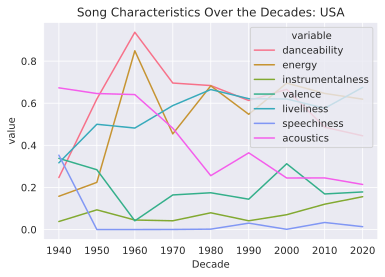

In [33]:
df_USA= df.filter(df.USA==1)
sound_features = ['danceability', 'energy', 'instrumentalness', 'valence', 'liveliness', 'speechiness', 'acoustics']
col_names = ['Decade']
col_names.extend(sound_features)

df_music_features = (df_USA.sample(.2, seed=42)
                       .groupBy(F.round(F.year(df.Release_date), -1))
                       .agg({feature: 'mean' for feature in sound_features})
                       .toDF(*col_names)
                       .orderBy('Decade')
                       .toPandas()
                       .dropna(axis=0)
                    )
sns.lineplot(data=pd.melt(df_music_features, 
                          ['Decade']),
                           x='Decade', 
                          y='value', 
                          hue='variable').set_title('Song Characteristics Over the Decades: USA');

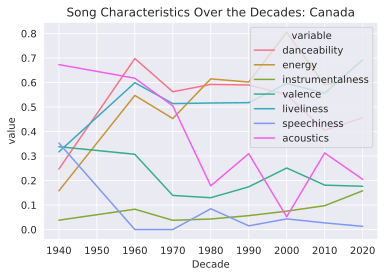

In [34]:
df_Canada= df.filter(df.Country0=='Canada')
sound_features = ['danceability', 'energy', 'instrumentalness', 'valence', 'liveliness', 'speechiness', 'acoustics']
col_names = ['Decade']
col_names.extend(sound_features)

df_music_features = (df_Canada.sample(.2, seed=42)
                       .groupBy(F.round(F.year(df.Release_date), -1))
                       .agg({feature: 'mean' for feature in sound_features})
                       .toDF(*col_names)
                       .orderBy('Decade')
                       .toPandas()
                       .dropna(axis=0)
                    )
sns.lineplot(data=pd.melt(df_music_features, 
                          ['Decade']),
                           x='Decade', 
                          y='value', 
                          hue='variable').set_title('Song Characteristics Over the Decades: Canada');

## Visualization

Let’s see how many genres there are in the track_df data frame:

 1   pop                38.36%
 2   hip hop            22.86%
 3   rap                8.67%
 4   latin              6.18%
 5   else               5.61%
 6   indie              4.69%
 7   rock               4.05%
 8   dance/electronic   3.68%
 9   house              3.01%
10   k-pop              2.89%


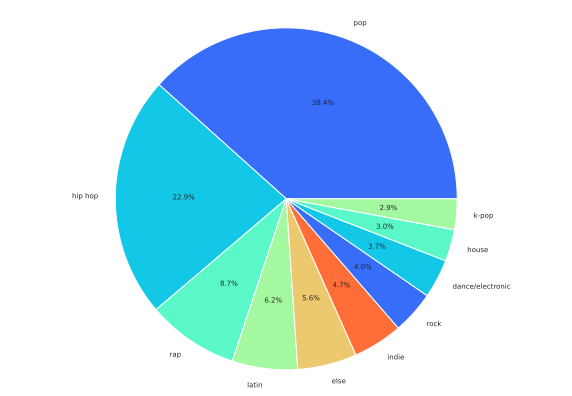

In [35]:
# Find percent of each common top 10 genre in the dataset
result_df = (df.groupBy("Genre_new")
               .count()
               .orderBy("count", ascending=False)
               .limit(10)
               .toPandas()
            )


labels = result_df.values[:,0].tolist()

df_genre = result_df['count'] / result_df['count'].sum()
sizes = df_genre.values.tolist()

for i in range(0,10):
  print("{:2}".format(i+1), " ", "{:16}".format(labels[i]), " ",  "{:2.2%}".format(sizes[i]))

colors = sns.color_palette('pastel')[0:5]

fig1, ax1 = plt.subplots(figsize=(10,7))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=False, textprops={'fontsize': 7})
ax1.axis('equal')
plt.show()

# this means highest pop music is there in dataset..

 1   hip hop            31.56%
 2   pop                28.82%
 3   rap                18.70%
 4   r&b/soul           4.13%
 5   country            3.79%
 6   rock               3.46%
 7   else               2.90%
 8   latin              2.51%
 9   dance/electronic   2.47%
10   boy band           1.67%


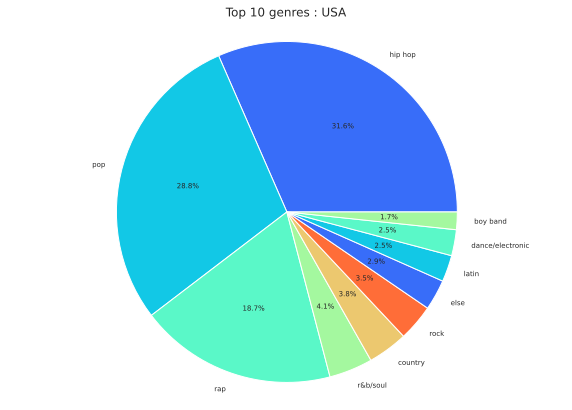

In [36]:
# Find percent of each common top 10 genre in the dataset
result_df = (df_USA.groupBy("Genre_new")
               .count()
               .orderBy("count", ascending=False)
               .limit(10)
               .toPandas()
            )


labels = result_df.values[:,0].tolist()

df_genre = result_df['count'] / result_df['count'].sum()
sizes = df_genre.values.tolist()

for i in range(0,10):
  print("{:2}".format(i+1), " ", "{:16}".format(labels[i]), " ",  "{:2.2%}".format(sizes[i]))

colors = sns.color_palette('pastel')[0:5]

fig1, ax1 = plt.subplots(figsize=(10,7))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=False, textprops={'fontsize': 7})
ax1.axis('equal')
plt.title("Top 10 genres : USA")

plt.show()

# this means highest pop music is there in dataset..

 1   hip hop            31.79%
 2   pop                30.73%
 3   rap                16.06%
 4   r&b/soul           4.82%
 5   rock               3.65%
 6   country            3.04%
 7   else               2.91%
 8   dance/electronic   2.72%
 9   house              2.27%
10   k-pop              2.00%


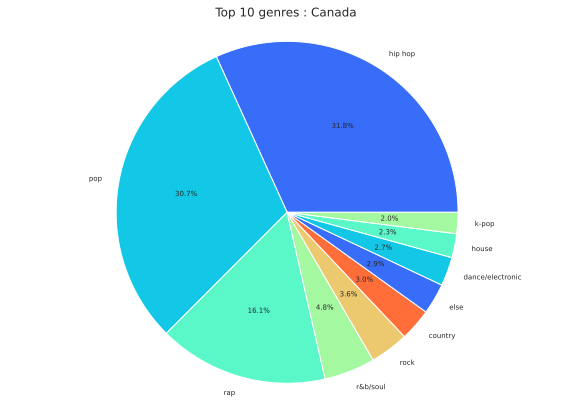

In [37]:
# Find percent of each common top 10 genre in the dataset
result_df = (df_Canada.groupBy("Genre_new")
               .count()
               .orderBy("count", ascending=False)
               .limit(10)
               .toPandas()
            )


labels = result_df.values[:,0].tolist()

df_genre = result_df['count'] / result_df['count'].sum()
sizes = df_genre.values.tolist()

for i in range(0,10):
  print("{:2}".format(i+1), " ", "{:16}".format(labels[i]), " ",  "{:2.2%}".format(sizes[i]))

colors = sns.color_palette('pastel')[0:5]

fig1, ax1 = plt.subplots(figsize=(10,7))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=False, textprops={'fontsize': 7})
ax1.axis('equal')
plt.title("Top 10 genres : Canada")
plt.show()

# this means highest pop music is there in dataset.

(170633, 151)


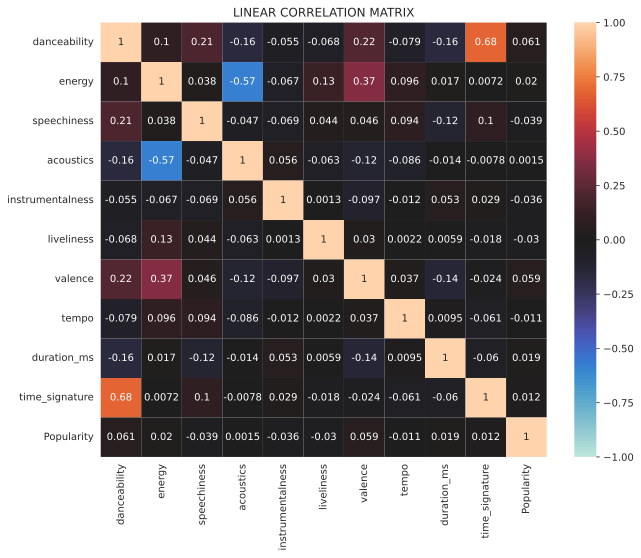

In [38]:
DF2 = df.toPandas()
print(DF2.shape)

lst = DF2.loc[:,'danceability':'time_signature']
# lst1 = DF2.loc[:,'Popularity']
# lst.append(lst1)
lst
df1 = DF2.loc[:,'danceability':'time_signature']

df_p = DF2.loc[:,'Popularity']
df_p

df_X = pd.concat([df1, df_p], axis=1)
df_X.head()

# Plot linear correlation matrix
import matplotlib.pyplot as plt
import seaborn as sns

fig,ax=plt.subplots(figsize=(10,8))
sns.heatmap(df_X.corr(),annot=True,cmap='icefire',vmin=-1,vmax=1,center=0,ax=ax)
plt.title('LINEAR CORRELATION MATRIX')
plt.show()

(6645, 151)
   danceability  energy key loudness mode  speechiness  acoustics  \
0         0.767   0.709   1    -4.47    1       0.3360   0.323000   
1         0.572   0.530   6   -8.521    0       0.0654   0.064700   
2         0.488   0.538   6   -4.974    1       0.0760   0.147000   
3         0.515   0.917   1   -7.312    1       0.0417   0.000209   
4         0.593   0.712   2   -6.325    0       0.0286   0.001840   

   instrumentalness  liveliness  valence       tempo  duration_ms  \
0          0.000000      0.0676    0.720  171.992996     258639.0   
1          0.000169      0.1270    0.120  170.138000     217613.0   
2          0.000000      0.3050    0.380   67.037003     205600.0   
3          0.000476      0.1450    0.409  121.987999     266187.0   
4          0.000000      0.1280    0.473  124.013000     231307.0   

   time_signature  Popularity  
0             4.0        8.00  
1             4.0      581.20  
2             4.0      100.25  
3             4.0       56.00 

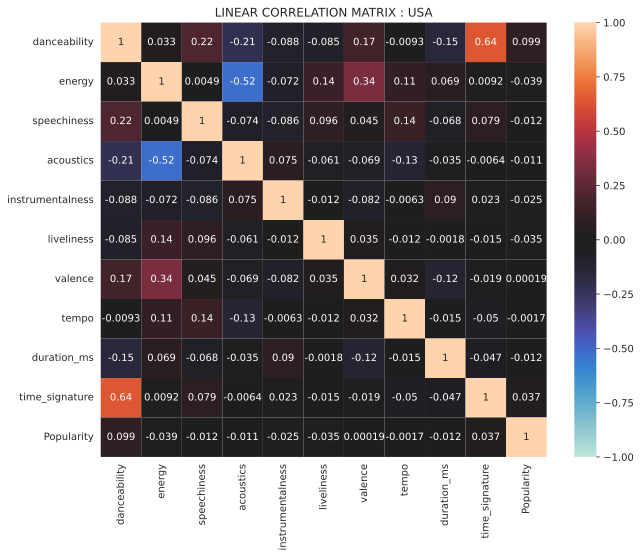

In [39]:
df_USA= df.filter(df.USA==1)
DF2 = df_USA.toPandas()
print(DF2.shape)

lst = DF2.loc[:,'danceability':'time_signature']
# lst1 = DF2.loc[:,'Popularity']
# lst.append(lst1)
lst
df1 = DF2.loc[:,'danceability':'time_signature']

df_p = DF2.loc[:,'Popularity']
df_p

df_X = pd.concat([df1, df_p], axis=1)
print(df_X.head())

# Plot linear correlation matrix
import matplotlib.pyplot as plt
import seaborn as sns

fig,ax=plt.subplots(figsize=(10,8))
sns.heatmap(df_X.corr(),annot=True,cmap='icefire',vmin=-1,vmax=1,center=0,ax=ax)
plt.title('LINEAR CORRELATION MATRIX : USA')
plt.show()

(5461, 151)
   danceability  energy key loudness mode  speechiness  acoustics  \
0         0.767   0.709   1    -4.47    1       0.3360   0.323000   
1         0.572   0.530   6   -8.521    0       0.0654   0.064700   
2         0.488   0.538   6   -4.974    1       0.0760   0.147000   
3         0.515   0.917   1   -7.312    1       0.0417   0.000209   
4         0.593   0.712   2   -6.325    0       0.0286   0.001840   

   instrumentalness  liveliness  valence       tempo  duration_ms  \
0          0.000000      0.0676    0.720  171.992996     258639.0   
1          0.000169      0.1270    0.120  170.138000     217613.0   
2          0.000000      0.3050    0.380   67.037003     205600.0   
3          0.000476      0.1450    0.409  121.987999     266187.0   
4          0.000000      0.1280    0.473  124.013000     231307.0   

   time_signature  Popularity  
0             4.0    31833.95  
1             4.0      418.00  
2             4.0       56.00  
3             4.0       78.40 

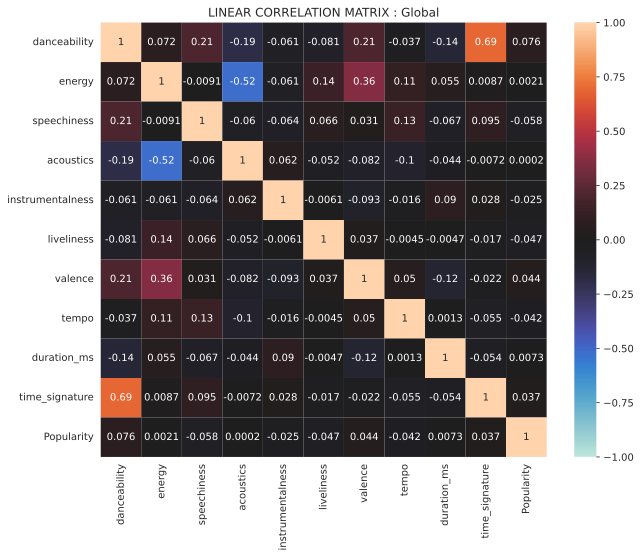

In [40]:
df_Global= df.filter(df.Country0=='Global')
DF2 = df_Global.toPandas()
print(DF2.shape)

lst = DF2.loc[:,'danceability':'time_signature']
# lst1 = DF2.loc[:,'Popularity']
# lst.append(lst1)
lst
df1 = DF2.loc[:,'danceability':'time_signature']

df_p = DF2.loc[:,'Popularity']
df_p

df_X = pd.concat([df1, df_p], axis=1)
print(df_X.head())

# Plot linear correlation matrix
import matplotlib.pyplot as plt
import seaborn as sns

fig,ax=plt.subplots(figsize=(10,8))
sns.heatmap(df_X.corr(),annot=True,cmap='icefire',vmin=-1,vmax=1,center=0,ax=ax)
plt.title('LINEAR CORRELATION MATRIX : Global')
plt.show()

(5461, 151)
   danceability  energy key loudness mode  speechiness  acoustics  \
0         0.767   0.709   1    -4.47    1       0.3360   0.323000   
1         0.572   0.530   6   -8.521    0       0.0654   0.064700   
2         0.488   0.538   6   -4.974    1       0.0760   0.147000   
3         0.515   0.917   1   -7.312    1       0.0417   0.000209   
4         0.593   0.712   2   -6.325    0       0.0286   0.001840   

   instrumentalness  liveliness  valence       tempo  duration_ms  \
0          0.000000      0.0676    0.720  171.992996     258639.0   
1          0.000169      0.1270    0.120  170.138000     217613.0   
2          0.000000      0.3050    0.380   67.037003     205600.0   
3          0.000476      0.1450    0.409  121.987999     266187.0   
4          0.000000      0.1280    0.473  124.013000     231307.0   

   time_signature  Popularity  
0             4.0    31833.95  
1             4.0      418.00  
2             4.0       56.00  
3             4.0       78.40 

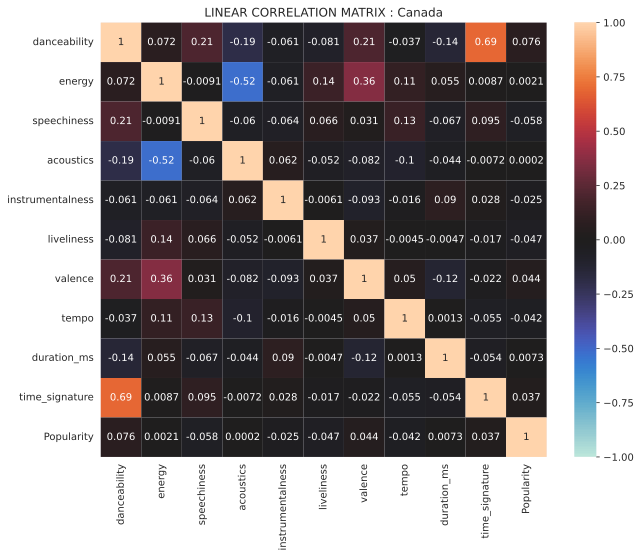

In [41]:
df_Canada= df.filter(df.Country0=='Canada')
DF2 = df_Global.toPandas()
print(DF2.shape)

lst = DF2.loc[:,'danceability':'time_signature']
# lst1 = DF2.loc[:,'Popularity']
# lst.append(lst1)
lst
df1 = DF2.loc[:,'danceability':'time_signature']

df_p = DF2.loc[:,'Popularity']
df_p

df_X = pd.concat([df1, df_p], axis=1)
print(df_X.head())

# Plot linear correlation matrix
import matplotlib.pyplot as plt
import seaborn as sns

fig,ax=plt.subplots(figsize=(10,8))
sns.heatmap(df_X.corr(),annot=True,cmap='icefire',vmin=-1,vmax=1,center=0,ax=ax)
plt.title('LINEAR CORRELATION MATRIX : Canada')
plt.show()

In [42]:
# df.select('Genre').distinct().count()

In [43]:
# df.select(["Title","Artist"]).distinct().count()

In [44]:
# numerical_features

In [45]:
df.corr("energy","popularity")

0.02022279230133238

In [46]:
df_USA= df.filter(df.USA==1)
df_USA[numerical_features].show()

+------------+------+----------------+-------+----------+-----------+---------+----------------+-------+-----------+--------------+
|danceability|energy|instrumentalness|valence|liveliness|speechiness|acoustics|instrumentalness|  tempo|duration_ms|time_signature|
+------------+------+----------------+-------+----------+-----------+---------+----------------+-------+-----------+--------------+
|       0.767| 0.709|             0.0|   0.72|    0.0676|      0.336|    0.323|             0.0|171.993|   258639.0|           4.0|
|       0.572|  0.53|         1.69E-4|   0.12|     0.127|     0.0654|   0.0647|         1.69E-4|170.138|   217613.0|           4.0|
|       0.488| 0.538|             0.0|   0.38|     0.305|      0.076|    0.147|             0.0| 67.037|   205600.0|           4.0|
|       0.515| 0.917|         4.76E-4|  0.409|     0.145|     0.0417|  2.09E-4|         4.76E-4|121.988|   266187.0|           4.0|
|       0.593| 0.712|             0.0|  0.473|     0.128|     0.0286|  0.001

In [47]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
vector_col="corr-features"
assembler=VectorAssembler(inputCols=numerical_features,
                          outputCol=vector_col)
df_vector=assembler.transform(df_USA).select(vector_col)
df_vector


DataFrame[corr-features: vector]

In [48]:
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]


In [49]:
corrmatrix=matrix.toArray().tolist()

In [50]:
# print(corrmatrix)

In [51]:
columns=numerical_features

In [52]:
df_corr=spark.createDataFrame(corrmatrix,columns)

In [53]:
df_corr.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|        danceability|              energy|    instrumentalness|             valence|          liveliness|         speechiness|           acoustics|    instrumentalness|               tempo|         duration_ms|      time_signature|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                 1.0| 0.03288605840210202|-0.08817253028922897| 0.16791941127099816|-0.08470113062560913| 0.21503064216926915|-0.21330044320987532|-0.08817253028922897|-0.00931777374608146|-0.14848190602358624|  0.6448338957848826|
| 0.03288605840210202|                 1.0| -0.0719744831705834| 0.3

In [54]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
vector_col = "corr_features" 
df_USA= df.filter(df.USA==1) # select one country for example USA
# df_USA[numerical_features].show()
# df_USA[numerical_features].printSchema()

assembler = VectorAssembler(inputCols=numerical_features, 
                            outputCol=vector_col)
assembler
df_vector = assembler.transform(df_USA).select(vector_col)



## Training

In [55]:
from numpy import allclose
from pyspark.ml.linalg import Vectors
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline


In [56]:
assembler = VectorAssembler(inputCols=numerical_features, 
                            outputCol='features')
gbt = GBTRegressor(labelCol="Popularity")
gbtPipeline = Pipeline(stages = [assembler, gbt])

train, test = df_USA.randomSplit([0.8, 0.2])
train.cache()
test.cache()
print(train.count()) 
print(test.count())


5280
1365


In [57]:
gbtModel = gbtPipeline.fit(train)

In [58]:
predictions = gbtModel.transform(test)
predictions.show(2)

+--------+--------------------+----------+--------------------+------------+------------+---------+----------------+--------+----------------+------------+------------+---------------+------------+------+---+--------+----+-----------+---------+----------------+----------+-------+-------+-----------+--------------+---------+------------------+-------------------+--------------+-------------+-------+-----------+------+------+--------+---------+----------------+----+----+-------+-----+-----+----+-----+-----+-----+---+---+--------+---+------+---------+----+----+------------+---------+----------+--------+-------+----+-----+----+-----+------------+-------+----+----+-------+--------+-----+--------+--------+-------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------+------------------+-------------+----------+---------+-------------+-------------

In [59]:
from pyspark.ml.evaluation import *

eval = RegressionEvaluator(labelCol="Popularity", predictionCol="prediction")
eval.evaluate(predictions)

10733.775171083096

In [60]:
predictions.corr('Popularity', "prediction")

0.03888301940263934

# MACHINE LEARNING

### Tuning USA GBT

In [61]:
assembler = VectorAssembler(inputCols=numerical_features, 
                            outputCol='features')
gbt = GBTRegressor(maxDepth=2, seed=42, labelCol="Popularity")

# gbt.setMaxIter(5)
# gbt.setMinWeightFractionPerNode(0.049) 

gbtPipeline = Pipeline(stages = [assembler, gbt])

# USA
train, test = df_USA.randomSplit([0.8, 0.2])
train.cache()
test.cache()
print(train.count()) 
print(test.count())

gbtModel = gbtPipeline.fit(train)

predictions = gbtModel.transform(test)
predictions.show(2)

eval = RegressionEvaluator(labelCol="Popularity", predictionCol="prediction")
print(eval.evaluate(predictions) )
predictions.corr('Popularity', "prediction")


5324
1321
+--------+--------------------+----------+--------------+--------------------+------------+-----------+----------------+--------+--------+------------+------------+---------------+------------+------+---+--------+----+-----------+---------+----------------+----------+-------+-------+-----------+--------------+---------+------------------+-------------------+--------------+-------------+-------+-----------+------+------+--------+---------+----------------+----+----+-------+-----+-----+----+-----+-----+-----+---+---+--------+---+------+---------+----+----+------------+---------+----------+--------+-------+----+-----+----+-----+------------+-------+----+----+-------+--------+-----+--------+--------+-------+----------+-----------------+------------+---------+--------+------------+-------------+----------+-------------+-------------+-----------+------------------+-------------+----------+---------+-------------+--------------+-----------+--------------+--------------+-------------

0.09870153881514136

In [62]:
predictions.select('features', 'Popularity', 'prediction').show(2)

+--------------------+----------+------------------+
|            features|Popularity|        prediction|
+--------------------+----------+------------------+
|[0.35199999809265...|     936.0|3190.1712594627106|
|[0.69099998474121...|    400.35|2162.9775472585857|
+--------------------+----------+------------------+
only showing top 2 rows



### Global GBT

In [63]:
#Global
# assembler = VectorAssembler(inputCols=numerical_features, 
#                             outputCol='features')
# gbt = GBTRegressor(maxDepth=2, seed=42, labelCol="Popularity")

# # gbt.setMaxIter(5)
# # gbt.setMinWeightFractionPerNode(0.049) 

# gbtPipeline = Pipeline(stages = [assembler, gbt])

train, test = df_Global.randomSplit([0.8, 0.2])
train.cache()
test.cache()
print(train.count()) 
print(test.count())

gbtModel = gbtPipeline.fit(train)

predictions = gbtModel.transform(test)
predictions.show(2)

eval = RegressionEvaluator(labelCol="Popularity", predictionCol="prediction")
print(eval.evaluate(predictions) )
print(predictions.corr('Popularity', "prediction"))
predictions.select('features', 'Popularity', 'prediction').show(2)

4354
1107
+--------+--------------------+------------------+--------------+--------------------+------------+-----------+----------------+--------+--------------------+------------+------------+---------------+------------+------+---+--------+----+-----------+---------+----------------+----------+-------+-------+-----------+--------------+---------+------------------+-------------------+--------------+-------------+-------+-----------+------+------+--------+---------+----------------+----+----+-------+-----+-----+----+-----+-----+-----+---+---+--------+---+------+---------+----+----+------------+---------+----------+--------+-------+----+-----+----+-----+------------+-------+----+---+-------+--------+-----+--------+--------+-------+-------------------+--------------------+-------------------+-------------------+--------------------+--------------------+-------------------+-------------------+------------------+------------------+-------------------+-------------------+-----------------

In [64]:
import pandas as pd

## Train Canada - GBT

In [65]:

# Canada
train, test = df_Canada.randomSplit([0.8, 0.2])
train.cache()
test.cache()
print(train.count()) 
print(test.count())

gbtModel = gbtPipeline.fit(train)

predictions = gbtModel.transform(test)
predictions.show(2)

eval = RegressionEvaluator(labelCol="Popularity", predictionCol="prediction")
print(eval.evaluate(predictions) )
predictions.corr('Popularity', "prediction")

print(predictions.corr('Popularity', "prediction"))
predictions.select('features', 'Popularity', 'prediction').show(2)



4534
1101
+--------+--------------------+----------+----------+--------------------+------------+-----------+----------------+--------+-----------+------------+------------+---------------+------------+------+---+--------+----+-----------+---------+----------------+----------+-------+-------+-----------+--------------+---------+------------------+-------------------+--------------+-------------+-------+-----------+------+------+--------+---------+----------------+----+----+-------+-----+-----+----+-----+-----+-----+---+---+--------+---+------+---------+----+----+------------+---------+----------+--------+-------+----+-----+----+-----+------------+-------+----+----+-------+--------+-----+--------+--------+-------+-------------------+--------------------+--------------------+-------------------+--------------------+--------------------+-------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+-----------------

In [66]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [67]:
numerical_features

['danceability',
 'energy',
 'instrumentalness',
 'valence',
 'liveliness',
 'speechiness',
 'acoustics',
 'instrumentalness',
 'tempo',
 'duration_ms',
 'time_signature']

In [68]:
assembler = VectorAssembler(inputCols=numerical_features, 
                            outputCol='features')
lr = LinearRegression(labelCol="Popularity")


lrPipeline = Pipeline(stages = [assembler, lr])
# Canada
train, test = df_Canada.randomSplit([0.8, 0.2])
train.cache()
test.cache()
print(train.count()) 
print(test.count())

lrModel = lrPipeline.fit(train)

predictions = lrModel.transform(test)
predictions.show(2)

eval = RegressionEvaluator(labelCol="Popularity", predictionCol="prediction")
print(eval.evaluate(predictions) )
predictions.corr('Popularity', "prediction")

print("R:" , predictions.corr('Popularity', "prediction"))
predictions.select('features', 'Popularity', 'prediction').show(2)

4475
1160
+--------+--------------------+----------+-------------+--------------------+------------+--------------------+----------------+--------+-------------+------------+------------+---------------+------------+------+---+--------+----+-----------+---------+----------------+----------+-------+-------+-----------+--------------+---------+------------------+-------------------+--------------+-------------+-------+-----------+------+------+--------+---------+----------------+----+----+-------+-----+-----+----+-----+-----+-----+---+---+--------+---+------+---------+----+----+------------+---------+----------+--------+-------+----+-----+----+-----+------------+-------+----+---+-------+--------+-----+--------+--------+-------+-------------------+--------------------+-------------------+-------------------+--------------------+-------------------+--------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+-----

In [69]:
# pd.DataFrame({'Coefficients': gcoefficient}, index = numerical_features)


## ML Without Pipeline

In [70]:
df_Canada= df.filter(df.Country0=='Canada')
df_Canada_TOP50 = df_Canada.filter(df_Canada.Top50_dummy == 1)
df_Canada_TOP50.count() / df_Canada.count()

0.33824312333629103

In [71]:
df_features = assembler.transform(df_Canada)
data = df_features.select('features', 'Popularity')

In [72]:
train, test = data.randomSplit([0.8, 0.2])
train.cache()
test.cache()
print(train.count())
print(test.count())

4488
1147


In [73]:
lr = LinearRegression(labelCol="Popularity")

model = lr.fit(train)

coeff = model.coefficients
pd.DataFrame({"VAriables Names": numerical_features, "Coefficients": coeff})

,VAriables Names,Coefficients
0,danceability,7674.615271
1,energy,-1097.798343
2,instrumentalness,-1078.353921
3,valence,357.987707
4,liveliness,-983.155661
5,speechiness,-4774.131996
6,acoustics,210.806565
7,instrumentalness,-1078.353921
8,tempo,-6.401412
9,duration_ms,0.001156


In [74]:
res = model.evaluate(test)

print(f"""
Linear Regression Results Report
==================================
RMSE:\t {res.rootMeanSquaredError}
MSE:\t {res.meanSquaredError}
R2:\t {res.r2}
Adj R2:\t{res.r2adj}
==================================
"""
)


Linear Regression Results Report
RMSE:	 11361.575964033193
MSE:	 129085408.38649677
R2:	 0.015132850134918052
Adj R2:	0.005587882162657376



# Regression Grid Search Cross Validation

In [84]:
df.show(2)

+--------+--------------------+----------+----------+------------+------------+-----------------+----------------+--------+----------+------------+------------+---------------+------------+------+---+--------+----+-----------+---------+----------------+----------+-------+-------+-----------+--------------+---------+------------------+-------------------+--------------+-------------+-------+-----------+------+------+--------+---------+----------------+----+----+-------+-----+-----+----+-----+-----+-----+---+---+--------+---+------+---------+----+----+------------+---------+----------+--------+-------+----+-----+----+-----+------------+-------+----+----+-------+--------+-----+--------+--------+-------+----------+-----------------+------------+---------+--------+------------+-------------+----------+-------------+-------------+-----------+------------------+-------------+----------+---------+-------------+--------------+-----------+--------------+--------------+---------------+-----------

In [93]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline


assembler = VectorAssembler(inputCols=numerical_features, 
                            outputCol='features')

rfModel = (RandomForestRegressor()
  .setLabelCol("Popularity") # Number of farmer's markets
  .setFeaturesCol("features")) # Various numerical features

# We now treat the trained model (ie. gbtModel, which is already defined) as an Estimator, wrapping it in a CrossValidator instance.
# We use a ParamGridBuilder to construct a grid of parameters to search over: maxBins and maxDepth.


train, test = df_Canada.randomSplit([0.8, 0.2])
train.cache()
test.cache()
print(train.count()) 
print(test.count())


# paramGrid = (ParamGridBuilder()
#   .addGrid(rfModel.maxBins, [3, 8])
#   .addGrid(rfModel.maxDepth, [5, 10])
#   .addGrid(rfModel.numTrees, [15])
#   .build())
paramGrid = (ParamGridBuilder()
             #.addGrid(rf.maxDepth, [2, 5, 10, 20, 30])
               .addGrid(rfModel.maxDepth, [2, 5, 10])
             #.addGrid(rfModel.maxBins, [10, 20, 40, 80, 100])
               .addGrid(rfModel.maxBins, [5, 10, 20])
             #.addGrid(rfModel.numTrees, [5, 20, 50, 100, 500])
               .addGrid(rfModel.numTrees, [5, 20, 50])
             .build())

stages = [assembler, rfModel]
 
pipeline = Pipeline(stages = [assembler, rfModel])
 
cv = (CrossValidator(numFolds=3) 
  .setEstimator(pipeline)
  .setEstimatorParamMaps(paramGrid)
  .setEvaluator(RegressionEvaluator().setLabelCol("Popularity")))
 
pipelineFitted = cv.fit(train)

4532
1103


In [94]:
print("The Best Parameters:\n--------------------")
print(pipelineFitted.bestModel.stages[0])
      
pipelineFitted.bestModel.stages[0].extractParamMap()

The Best Parameters:
--------------------
VectorAssembler_140bd299e2fc


{Param(parent='VectorAssembler_140bd299e2fc', name='handleInvalid', doc="How to handle invalid data (NULL and NaN values). Options are 'skip' (filter out rows with invalid data), 'error' (throw an error), or 'keep' (return relevant number of NaN in the output). Column lengths are taken from the size of ML Attribute Group, which can be set using `VectorSizeHint` in a pipeline before `VectorAssembler`. Column lengths can also be inferred from first rows of the data since it is safe to do so but only in case of 'error' or 'skip')."): 'error',
 Param(parent='VectorAssembler_140bd299e2fc', name='outputCol', doc='output column name.'): 'features',
 Param(parent='VectorAssembler_140bd299e2fc', name='inputCols', doc='input column names.'): ['danceability',
  'energy',
  'instrumentalness',
  'valence',
  'liveliness',
  'speechiness',
  'acoustics',
  'instrumentalness',
  'tempo',
  'duration_ms',
  'time_signature']}

In [95]:
holdout2 = (pipelineFitted.bestModel
  .transform(test)
  .selectExpr("prediction as raw_prediction", 
    "double(round(prediction)) as prediction", 
    "Popularity"))
display(holdout2)

DataFrame[raw_prediction: double, prediction: double, Popularity: double]

In [88]:
from pyspark.mllib.evaluation import RegressionMetrics

In [96]:
rm2 = (RegressionMetrics(
  holdout2.select("prediction", "Popularity").rdd.map(lambda x:
  (x[0], x[1]))))
 
print("MSE: ", rm2.meanSquaredError)
print("MAE: ", rm2.meanAbsoluteError)
print("RMSE Squared: ", rm2.rootMeanSquaredError)
print("R Squared: ", rm2.r2)
print("Explained Variance: ", rm2.explainedVariance, "\n")

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:159: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



MSE:  137880759.99927697
MAE:  6152.764415231191
RMSE Squared:  11742.263836214759
R Squared:  0.0161425460231569
Explained Variance:  1660976.636168237 



## Regression on to 50

In [98]:
train

DataFrame[Country0: string, Uri: string, Popularity: double, Title: string, Artist: string, Album/Single: string, Genre: string, Artist_followers: string, Explicit: string, Album9: string, Release_date: date, Track_number: string, Tracks_in_album: string, danceability: float, energy: float, key: string, loudness: string, mode: string, speechiness: float, acoustics: float, instrumentalness: float, liveliness: float, valence: float, tempo: float, duration_ms: float, time_signature: float, Genre_new: string, Days_since_release: string, Released_after_2017: double, Explicit_false: double, Explicit_true: int, album31: int, compilation: int, single: int, bolero: int, boy band: int, country36: int, dance/electronic: int, else: int, funk: int, hip hop: int, house: int, indie: int, jazz: int, k-pop: int, latin: int, metal: int, opm: int, pop: int, r&b/soul: int, rap: int, reggae: int, reggaeton: int, rock: int, trap: int, syuzhet_norm: double, bing_norm: double, afinn_norm: double, nrc_norm: do

In [99]:
# Canada
train, test = df_Canada_TOP50.randomSplit([0.8, 0.2])
train.cache()
test.cache()
print(train.count()) 
print(test.count())

rfModel = (RandomForestRegressor()
  .setLabelCol("Popularity") # Number of farmer's markets
  .setFeaturesCol("features")) # Various numerical features

# We now treat the trained model (ie. gbtModel, which is already defined) as an Estimator, wrapping it in a CrossValidator instance.
# We use a ParamGridBuilder to construct a grid of parameters to search over: maxBins and maxDepth.

paramGrid = (ParamGridBuilder()
  .addGrid(rfModel.maxBins, [3, 8])
  .addGrid(rfModel.maxDepth, [5, 10])
  .addGrid(rfModel.numTrees, [15])
  .build())

stages = [assembler, rfModel]
 
pipeline = Pipeline().setStages(stages)
 
cv = (CrossValidator(numFolds=3) 
  .setEstimator(pipeline) # the estimator can also just be an individual model rather than a pipeline
  .setEstimatorParamMaps(paramGrid)
  .setEvaluator(RegressionEvaluator().setLabelCol("Popularity")))
 
pipelineFitted = cv.fit(train)

print("The Best Parameters:\n--------------------")
print(pipelineFitted.bestModel.stages[0])
      
pipelineFitted.bestModel.stages[0].extractParamMap()


holdout2 = (pipelineFitted.bestModel
  .transform(test)
  .selectExpr("prediction as raw_prediction", 
    "double(round(prediction)) as prediction", 
    "Popularity"))
display(holdout2)


rm2 = (RegressionMetrics(
  holdout2.select("prediction", "Popularity").rdd.map(lambda x:
  (x[0], x[1]))))
 
print("MSE: ", rm2.meanSquaredError)
print("MAE: ", rm2.meanAbsoluteError)
print("RMSE Squared: ", rm2.rootMeanSquaredError)
print("R Squared: ", rm2.r2)
print("Explained Variance: ", rm2.explainedVariance, "\n")

1524
382
The Best Parameters:
--------------------
VectorAssembler_140bd299e2fc


DataFrame[raw_prediction: double, prediction: double, Popularity: double]

MSE:  349848240.8040513
MAE:  11324.138350785344
RMSE Squared:  18704.230558995238
R Squared:  0.011523486996607546
Explained Variance:  10084800.174383752 



/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:159: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



# Random Forest

In [ ]:
! pip install mlflow

In [ ]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
# import mlflow

In [100]:
rfModel = (RandomForestRegressor()
  .setLabelCol("Popularity") # Number of farmer's markets
  .setFeaturesCol("features")) # Various numerical features

paramGrid = (ParamGridBuilder()
  .addGrid(rfModel.maxDepth, [10, 15])
  .addGrid(rfModel.numTrees, [15])
  .build())

stages = [rfModel, assembler]

pipeline = Pipeline(stages = [assembler, rfModel ])

cv = (CrossValidator(numFolds=3) 
  .setEstimator(pipeline) # the estimator can also just be an individual model rather than a pipeline
  .setEstimatorParamMaps(paramGrid)
  .setEvaluator(RegressionEvaluator().setLabelCol("Popularity")))

pipelineFitted = cv.fit(train)

In [101]:
print("The Best Parameters:\n--------------------")
print(pipelineFitted.bestModel.stages[0])
      
pipelineFitted.bestModel.stages[0].extractParamMap()

The Best Parameters:
--------------------
VectorAssembler_140bd299e2fc


{Param(parent='VectorAssembler_140bd299e2fc', name='handleInvalid', doc="How to handle invalid data (NULL and NaN values). Options are 'skip' (filter out rows with invalid data), 'error' (throw an error), or 'keep' (return relevant number of NaN in the output). Column lengths are taken from the size of ML Attribute Group, which can be set using `VectorSizeHint` in a pipeline before `VectorAssembler`. Column lengths can also be inferred from first rows of the data since it is safe to do so but only in case of 'error' or 'skip')."): 'error',
 Param(parent='VectorAssembler_140bd299e2fc', name='outputCol', doc='output column name.'): 'features',
 Param(parent='VectorAssembler_140bd299e2fc', name='inputCols', doc='input column names.'): ['danceability',
  'energy',
  'instrumentalness',
  'valence',
  'liveliness',
  'speechiness',
  'acoustics',
  'instrumentalness',
  'tempo',
  'duration_ms',
  'time_signature']}

In [ ]:
# transformedDF = pipelineModel.transform(test)
# transformedDF.show(10)

In [ ]:
# predictions = cv.transform(test)
# predictions.show(2)

# eval = RegressionEvaluator(labelCol="Popularity", predictionCol="prediction")
# print(eval.evaluate(predictions) )
# predictions.corr('Popularity', "prediction")

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

In [ ]:
# assembler = VectorAssembler(inputCols=numerical_features, 
#                             outputCol='features')

# rf = RandomForestClassifier(numTrees=3, maxDepth=2, labelCol="Popularity", seed=42)

# rfPipeline = Pipeline(stages = [assembler, rf])

# td = rfPipeline.transform(df_USA)

# rfModel = rfPipeline.fit(td)

# predictions = rfModel.transform(test)
# predictions.show(2)

# predictions.featureImportances


Some observations:

Find top 20 tracks sorted by popularity for each of top 10 genres:

Popular tracks different from all the tracks in the dataset

In [ ]:
# feat_cols = ['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']
# top_100_feat = pd.DataFrame(columns=feat_cols)
# for i, track in by_track_pop[:100].iterrows():
#   features = tf_df[tf_df['id'] == track['track_id']]
#   top_100_feat = top_100_feat.append(features, ignore_index=True)
# top_100_feat = top_100_feat[feat_cols]

# from sklearn import preprocessing
# mean_vals = pd(columns=feat_cols)
# mean_vals = mean_vals.append(top_100_feat.mean(), ignore_index=True)
# mean_vals = mean_vals.append(tf_df[feat_cols].mean(), ignore_index=True)
# print(mean_vals)

# import plotly.graph_objects as go
# import plotly.offline as pyo
# fig = go.Figure(
#     data=[
#         go.Scatterpolar(r=mean_vals.iloc[0], theta=feat_cols, fill='toself', name='Top 100'),
#         go.Scatterpolar(r=mean_vals.iloc[1], theta=feat_cols, fill='toself', name='All'),
#     ],
#     layout=go.Layout(
#         title=go.layout.Title(text='Feature comparison'),
#         polar={'radialaxis': {'visible': True}},
#         showlegend=True
#     )
# )

# #pyo.plot(fig)
# fig.show()

## Modeling

Model 1: Linear Regression

1.Set the variables

In [ ]:
# X = [features]
# y = ['popularity']

In [ ]:
# #Split our data
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression
# X_train, X_test, y_train, y_test = train_test_split(X[features], y, train_size=0.5, random_state=8)

In [ ]:
# # Train our model
# lr = LinearRegression()
# lr.fit(X_train, y_train)
# lr.score(X_test, y_test)

In [ ]:
#Now let’s pass a predict method to our testing data.
y_pred = lr.predict(X_test)

In [ ]:
# #Finally, we can print out three key metrics to determine model fit.
# print(metrics.mean_absolute_error(y_test, y_pred))
# print(metrics.mean_squared_error(y_test, y_pred))
# print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Conclusion

Model 2: Decision Tree

In [ ]:
# from sklearn.tree import DecisionTreeRegressor
# max_depth_range = range(1, 15)
# RMSE_scores = []
# from sklearn.model_selection import cross_val_score
# for depth in max_depth_range:
#     treereg = DecisionTreeRegressor(max_depth=depth, random_state=1)
#     MSE_scores = cross_val_score(treereg, X, y, cv=5, scoring='neg_mean_squared_error')
#     RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))
# plt.plot(max_depth_range, RMSE_scores);
# plt.xlabel('max_depth');
# plt.ylabel('RMSE (lower is better)');

Model 3: Random Forest


# New Section

In [ ]:
# df

In [ ]:
# ! install kaggle_secrets

In [ ]:
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# SPOTIFY_CLIENT_ID = user_secrets.get_secret("SPOTIFY_CLIENT_ID")
# SPOTIFY_CLIENT_SECRET = user_secrets.get_secret("SPOTIFY_CLIENT_SECRET")

In [ ]:
#pip install pyspark_dist_explore

In [102]:
!pip install pyspark_dist_explore

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Code from Irina T August 14

In [103]:
df_stream = df
pca_col = [
 'danceability',
 'energy',
 'speechiness',
 'acoustics',
 'instrumentalness',
 'liveliness',
 'valence',
 'tempo']

from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
import seaborn as sns
x = df_Canada.na.drop("any")
x1 = x.toPandas()


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

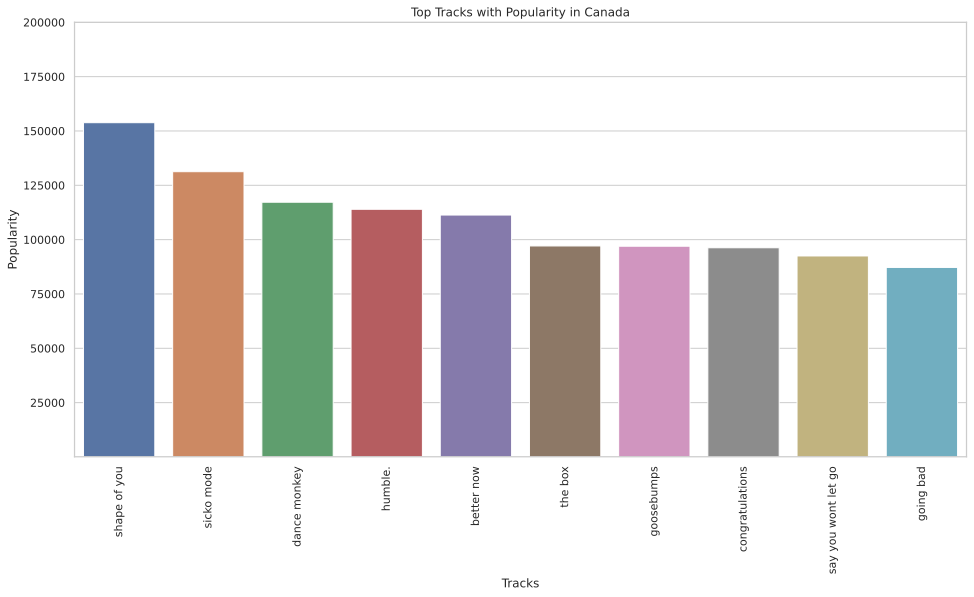

In [104]:
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
y = x1.groupby("Title")["Popularity"].mean().sort_values(ascending=False).head(10)
ax = sns.barplot(y.index, y)
ax.set_title('Top Tracks with Popularity in Canada')
ax.set_ylabel('Popularity')
ax.set_xlabel('Tracks')
ax.set_ylim(70,200000)
plt.xticks(rotation = 90)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

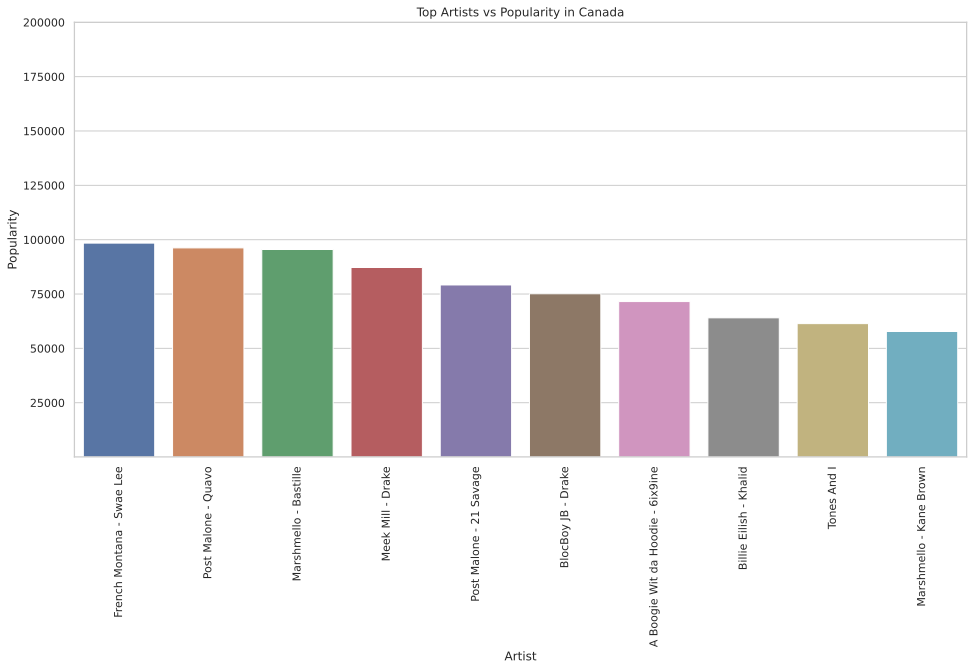

In [105]:
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
y2 = x1.groupby("Artist")["Popularity"].mean().sort_values(ascending=False).head(10)
ax = sns.barplot(y2.index,y2)
ax.set_title('Top Artists vs Popularity in Canada')
ax.set_ylabel('Popularity')
ax.set_xlabel('Artist')
ax.set_ylim(70,200000)
plt.xticks(rotation = 90)

In [106]:
x = df_USA.na.drop("any")
x1 = x.toPandas()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

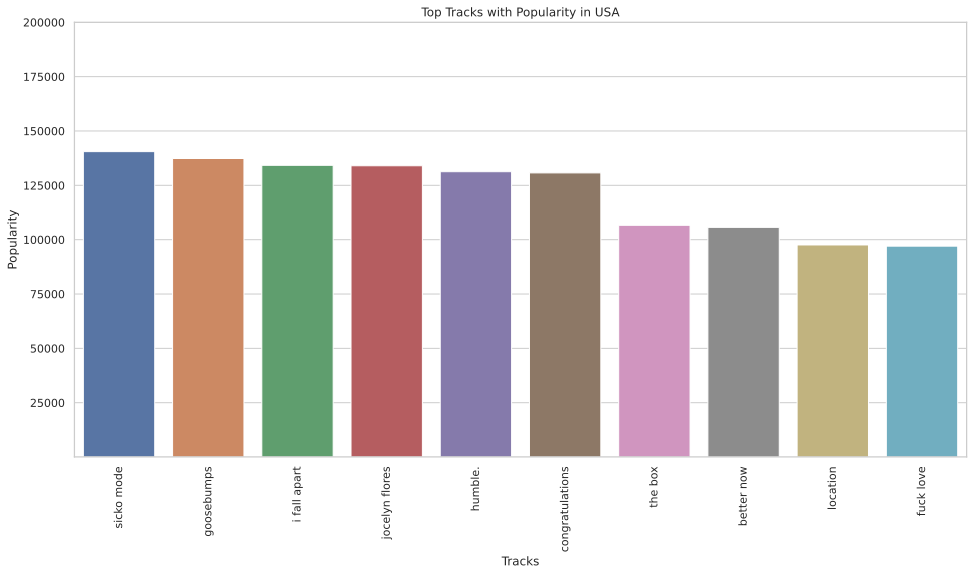

In [107]:
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
y = x1.groupby("Title")["Popularity"].mean().sort_values(ascending=False).head(10)
ax = sns.barplot(y.index, y)
ax.set_title('Top Tracks with Popularity in USA')
ax.set_ylabel('Popularity')
ax.set_xlabel('Tracks')
ax.set_ylim(70,200000)
plt.xticks(rotation = 90)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

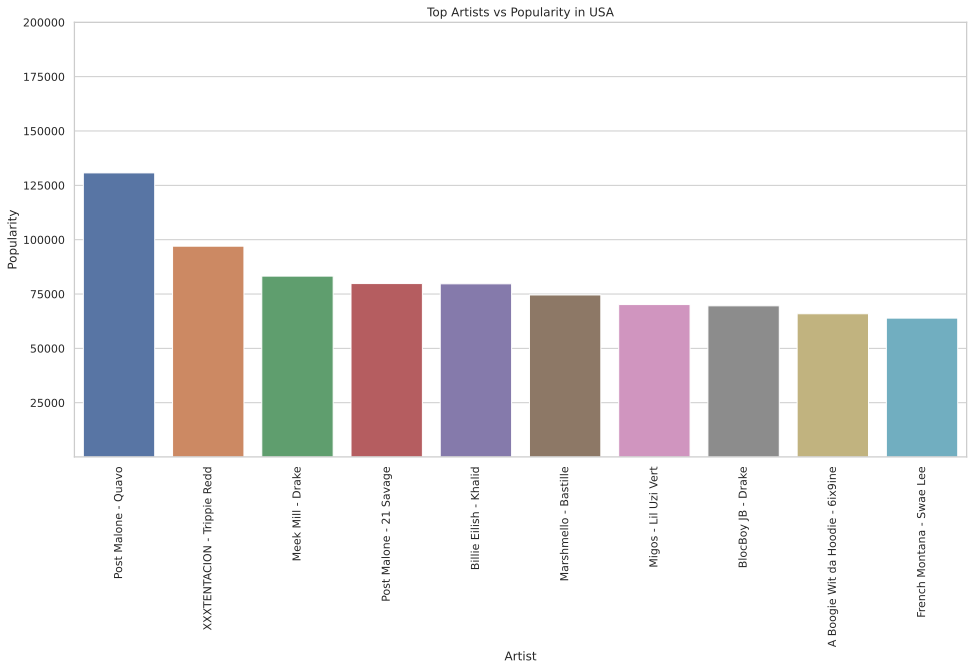

In [108]:
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
y2 = x1.groupby("Artist")["Popularity"].mean().sort_values(ascending=False).head(10)
ax = sns.barplot(y2.index,y2)
ax.set_title('Top Artists vs Popularity in USA')
ax.set_ylabel('Popularity')
ax.set_xlabel('Artist')
ax.set_ylim(70,200000)
plt.xticks(rotation = 90)